# Satellite data

## Objectives

- Loading and visualizing satellite data
- Loading and visualizing point data (e.g., cyclone tracks)
- Georeferencing such datasets

## Resources

- [Modis/Aqua Corrected Reflectance](https://worldview.earthdata.nasa.gov/?v=-106.453125,-133.3125,321.328125,117&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor,MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=false&t=2023-02-17-T23%3A25%3A50Z)
- https://nasa-gibs.github.io/gibs-api-docs/available-visualizations/#visualization-product-catalog
- [LINZ](https://data.linz.govt.nz)

In [1]:
# for plotting
import matplotlib.pyplot as plt

# for map projections
import cartopy.crs as ccrs

# rasterio for GeoTIFF data
import rasterio as rio

# pandas for CSV data
import pandas as pd

# tqdm for fancy progress bars
from tqdm.notebook import tqdm

# setting this path so we have to type less
# PATH = "/nesi/nobackup/nesi99991/ASP_winterschool2023"
PATH = "../"

(3, 793, 789)
BoundingBox(left=147.1765999999969, bottom=-57.65517971752841, right=216.48597999999686, top=12.044193282471813)


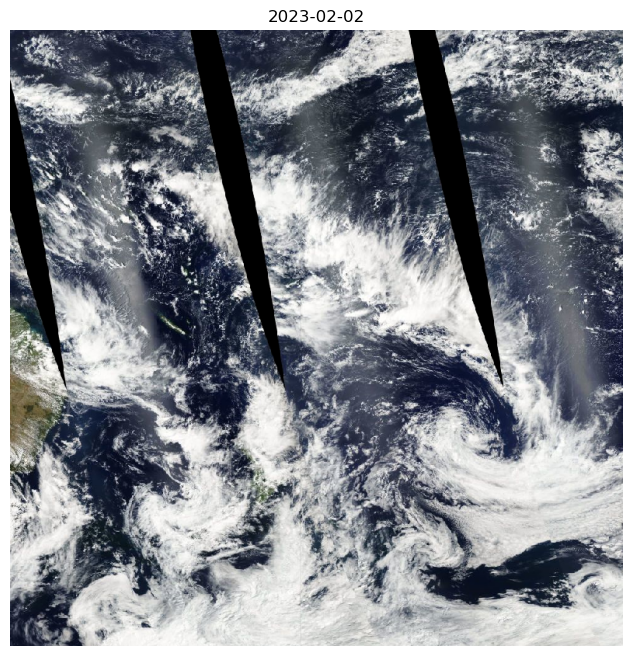

In [2]:
date_ = "2023-02-02"

src = rio.open(PATH+f"/data/satellite/snapshot-{date_}T00_00_00Z.tiff")
img = src.read()
print(img.shape) #check the dimensions
img = img.transpose(1,2,0) # -> shape=(H,W,3).

#get the upper and lower bounds of image and define map extent
print(src.bounds)
img_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.imshow(img)
ax.set_title(date_)
ax.set_aspect("equal")
ax.axis("off");

## Georeferencing the image

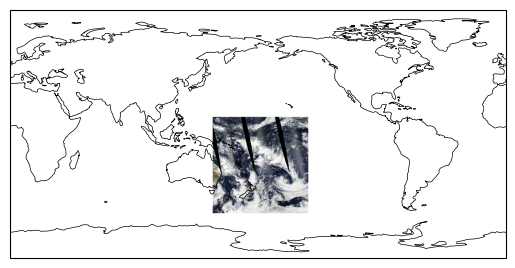

In [3]:
# define the PlateCarree projection and center the image in the Pacific
fig, ax = plt.subplots(1,1,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})
ax.coastlines(lw=0.5)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

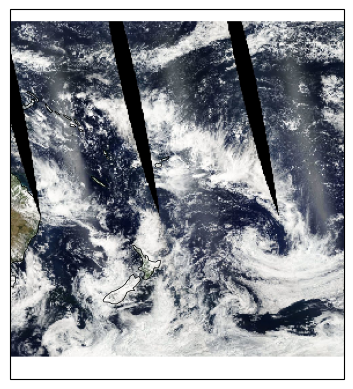

In [4]:
ax.set_extent(img_extent)
fig

## Load the *TC Gabrielle* track and add to satellite figure

In [5]:
# Track data adapted from https://commons.wikimedia.org/wiki/File:Gabrielle_2023_path.png
df = pd.read_csv(PATH+"/data/gabrielle_track.csv",index_col=0).iloc[::4]
tc_lons = df["longitude"]
tc_lats = df["latitude"]
df.head()

,latitude,longitude
time,,
2023-02-04-12:00:00,-11.6,167.0
2023-02-05-12:00:00,-12.4,161.8
2023-02-06-12:00:00,-12.4,156.1
2023-02-07-12:00:00,-14.0,153.9
2023-02-08-12:00:00,-16.8,152.6


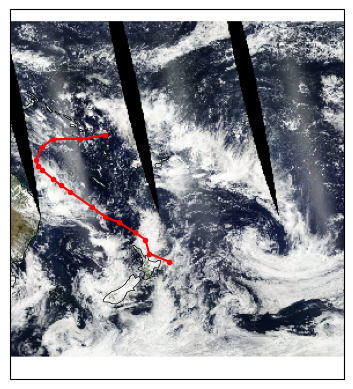

In [6]:
#plot lat/lon points connected by a red line
ax.plot(tc_lons,tc_lats,'r.-',transform=ccrs.PlateCarree(),zorder=10)
fig

**Exercise**

1. Go to https://worldview.earthdata.nasa.gov/, download a snapshot, load the `GeoTIFF` file, and create a georeferenced map.

## Creating an animation [Optional]

In [7]:
dates = [f"2023-02-{i:02}" for i in range(4,15)] 

images = []

for date_ in tqdm(dates):
    src = rio.open(PATH+f"/data/satellite/snapshot-{date_}T00_00_00Z.tiff")
    img = src.read()
    # print(img.shape)
    img = img.transpose(1,2,0) # -> shape=(H,W,3).
    images.append(img)

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(1,1)

im = ax.imshow(images[0],extent=img_extent)
ax.set_title(dates[0])
ax.axis("off")
# find the coordinates of the track at that first date in the cyclone track data
date = dates[0]+"-12:00:00"
coord = df.loc[:date]
l, = ax.plot(coord["longitude"],coord["latitude"], 'r.-')

# animation function.  This is called sequentially
def animate(i):
    im.set_array(images[i])
    ax.set_title(dates[i])
    coord = df.loc[:dates[i]+"-12:00:00"]
    l.set_xdata(coord["longitude"].values)
    l.set_ydata(coord["latitude"].values)
    return im,l,

anim = animation.FuncAnimation(fig, animate, frames=len(dates), interval=800, blit=True)
plt.close()

In [9]:
HTML(anim.to_html5_video())

## Geostationary satellites [Optional]

In [10]:
src = rio.open(PATH+"/data/satellite/himawari-8_snapshot-2023-08-03T01_40_00Z.tif")
img2 = src.read()
print(img2.shape)
img2 = img2.transpose(1,2,0) # -> shape=(H,W,3).

(4, 2048, 1971)


/usr/local/Caskroom/miniforge/base/envs/asp_winterschool/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


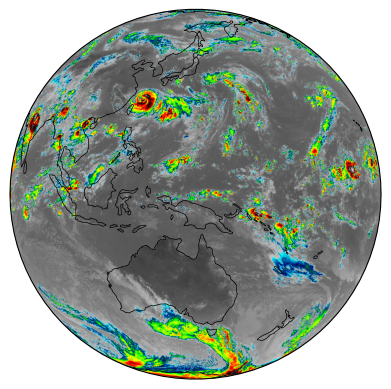

In [11]:
fig, ax = plt.subplots(1,1,subplot_kw={"projection": ccrs.Geostationary(central_longitude=140.7)})
ax.coastlines(lw=0.5)
ax.imshow(img2, origin='upper', extent=[55,228,-90,90], transform=ccrs.PlateCarree())

### ...but on a different projection

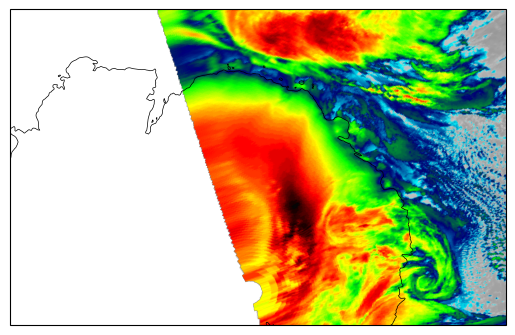

In [12]:
fig, ax = plt.subplots(1,1,subplot_kw={"projection": ccrs.epsg(3032)})
ax.coastlines(lw=0.5)
ax.imshow(img2, origin='upper', extent=[55,228,-90,90], transform=ccrs.PlateCarree())

## Our location [Optional]

(3600, 2400, 3)
[1732000, 1756000, 5406000, 5442000]


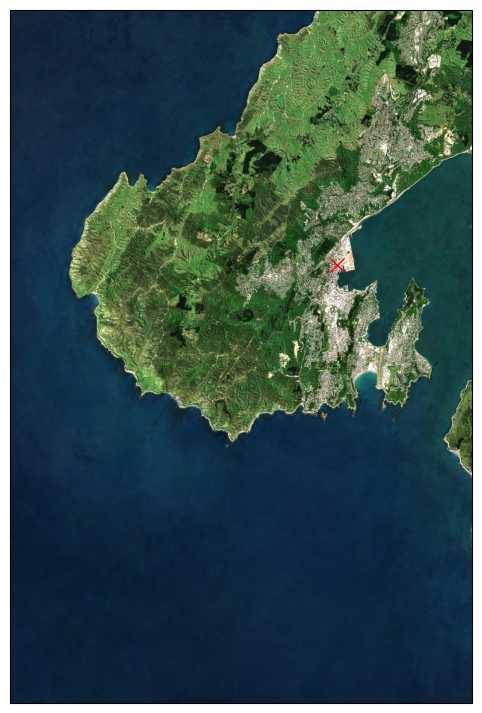

In [13]:
img3 = plt.imread(PATH+"/data/satellite/BQ31.jpg")
print(img3.shape)

coords = (-41.27878654088185, 174.77882904765005)

dx = 10
dy = -10
x0 = 1732005 - dx//2
x1 = x0 + dx*img3.shape[1]
y1 = 5441995 - dy//2
y0 = y1 + dy*img3.shape[0]
extent = [x0,x1,y0,y1]

print(extent)

fig, ax = plt.subplots(1,1,subplot_kw={"projection": ccrs.epsg(2193)},figsize=(6,9))
ax.imshow(img3,origin="upper", extent=extent, transform=ccrs.epsg(2193))
ax.plot(coords[1],coords[0],'rx',ms=10,transform=ccrs.PlateCarree())